# English language models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import lru_cache
from itertools import combinations, product
import os

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import numpy as np
from scipy.stats import pearsonr, gmean
from tqdm import tqdm

from gest import gest, stereotype_names
from utils import bootstrap_ci, set_size, visualize_corr

In [3]:
models_str = """
bert-base-uncased 109514298
roberta-base 124697433
albert-base-v2 11221680
bert-base-multilingual-cased 177974523
xlm-roberta-base 278295186
xlm-roberta-large 560142482
facebook/xlm-v-base 779396349
facebook/xlm-roberta-xl 3482741760
distilbert-base-uncased 66985530
google/electra-large-generator 51295290
google/electra-base-generator 33740602
"""

gmodels_str = """
EleutherAI/pythia-70m 70426624
EleutherAI/pythia-160m 162322944
EleutherAI/pythia-410m 405334016
EleutherAI/pythia-1b 1011781632
EleutherAI/pythia-1.4b 1414647808
EleutherAI/pythia-2.8b 2775208960
EleutherAI/pythia-6.9b 6857302016
EleutherAI/pythia-12b 11846072320
mistralai/Mistral-7B-v0.1 7241732096
mistralai/Mistral-7B-Instruct-v0.2 7241732096
openchat/openchat-3.5-0106 7241748480
gpt2 124439808
openai-community/gpt2-medium 354823168
openai-community/gpt2-large 774030080
openai-community/gpt2-xl 1557611200
microsoft/phi-1 1418270720
microsoft/phi-1_5 1418270720
microsoft/phi-2 2779683840
meta-llama/Llama-2-7b-hf 6738415616
meta-llama/Llama-2-7b-chat-hf 6738415616
meta-llama/Llama-2-13b-hf 13015864320
meta-llama/Llama-2-13b-chat-hf 13015864320
"""

def str_to_dict(models_str):
    return {
        line.split()[0]: int(line.split()[1])
        for line in models_str.strip().split('\n')
    }

models = str_to_dict(models_str)
gmodels = str_to_dict(gmodels_str)

def short_model_name(model):
    for s in ('uncased', 'v2', 'cased', 'generator'):
        if model.endswith('-' + s):
            model = model[:-len(s)-1]
    model = model.split('/')[-1]
    if model.endswith('lingual'):
        model = model[:-7]
    return model

In [4]:
def file_results(filename):
    return list(map(float, open(filename, 'r').readlines()))

def model_template_file(model, template_id, generative=False):
    model = model.split('/')[-1]
    task = 'english_glm' if generative else 'english_mlm'
    return f'./data/predictions/{task}/{model}_template-{template_id}.txt'


@lru_cache
def r_i(filename, stereotype_id, bootstrap=True):
    """
    Average score for stereotype _i_
    """
    vals = [
        val
        for val, gest_stereotype_id in zip(file_results(filename), gest.stereotype)
        if gest_stereotype_id == stereotype_id
    ]

    if bootstrap:
        return list(map(np.exp, bootstrap_ci(vals)))
    else:
        return np.exp(np.mean(vals))

def r_is(filename, bootstrap=True):
    """
    Averages for all 16 stereotypes
    """
    return [
        r_i(filename, stereotype_id, bootstrap)
        for stereotype_id in range(1, 17)
    ]

def r_f(filename):
    """
    Average score $r_i$ for female stereotypes
    """
    return gmean([
        r_i(filename, stereotype_id, bootstrap=False)
        for stereotype_id in range(1, 8)
    ]) 

def r_m(filename):
    """
    Average score $r_i$ for male stereotypes
    """
    return gmean([
        r_i(filename, stereotype_id, bootstrap=False)
        for stereotype_id in range(8, 17)
    ]) 

def g_s(filename):
    """
    Overall stereotype rate
    """
    return r_m(filename) / r_f(filename)

def r_i_ranks(filename):
    return np.argsort(np.argsort(r_is(filename, bootstrap=False))) + 1

## MLM visualizations

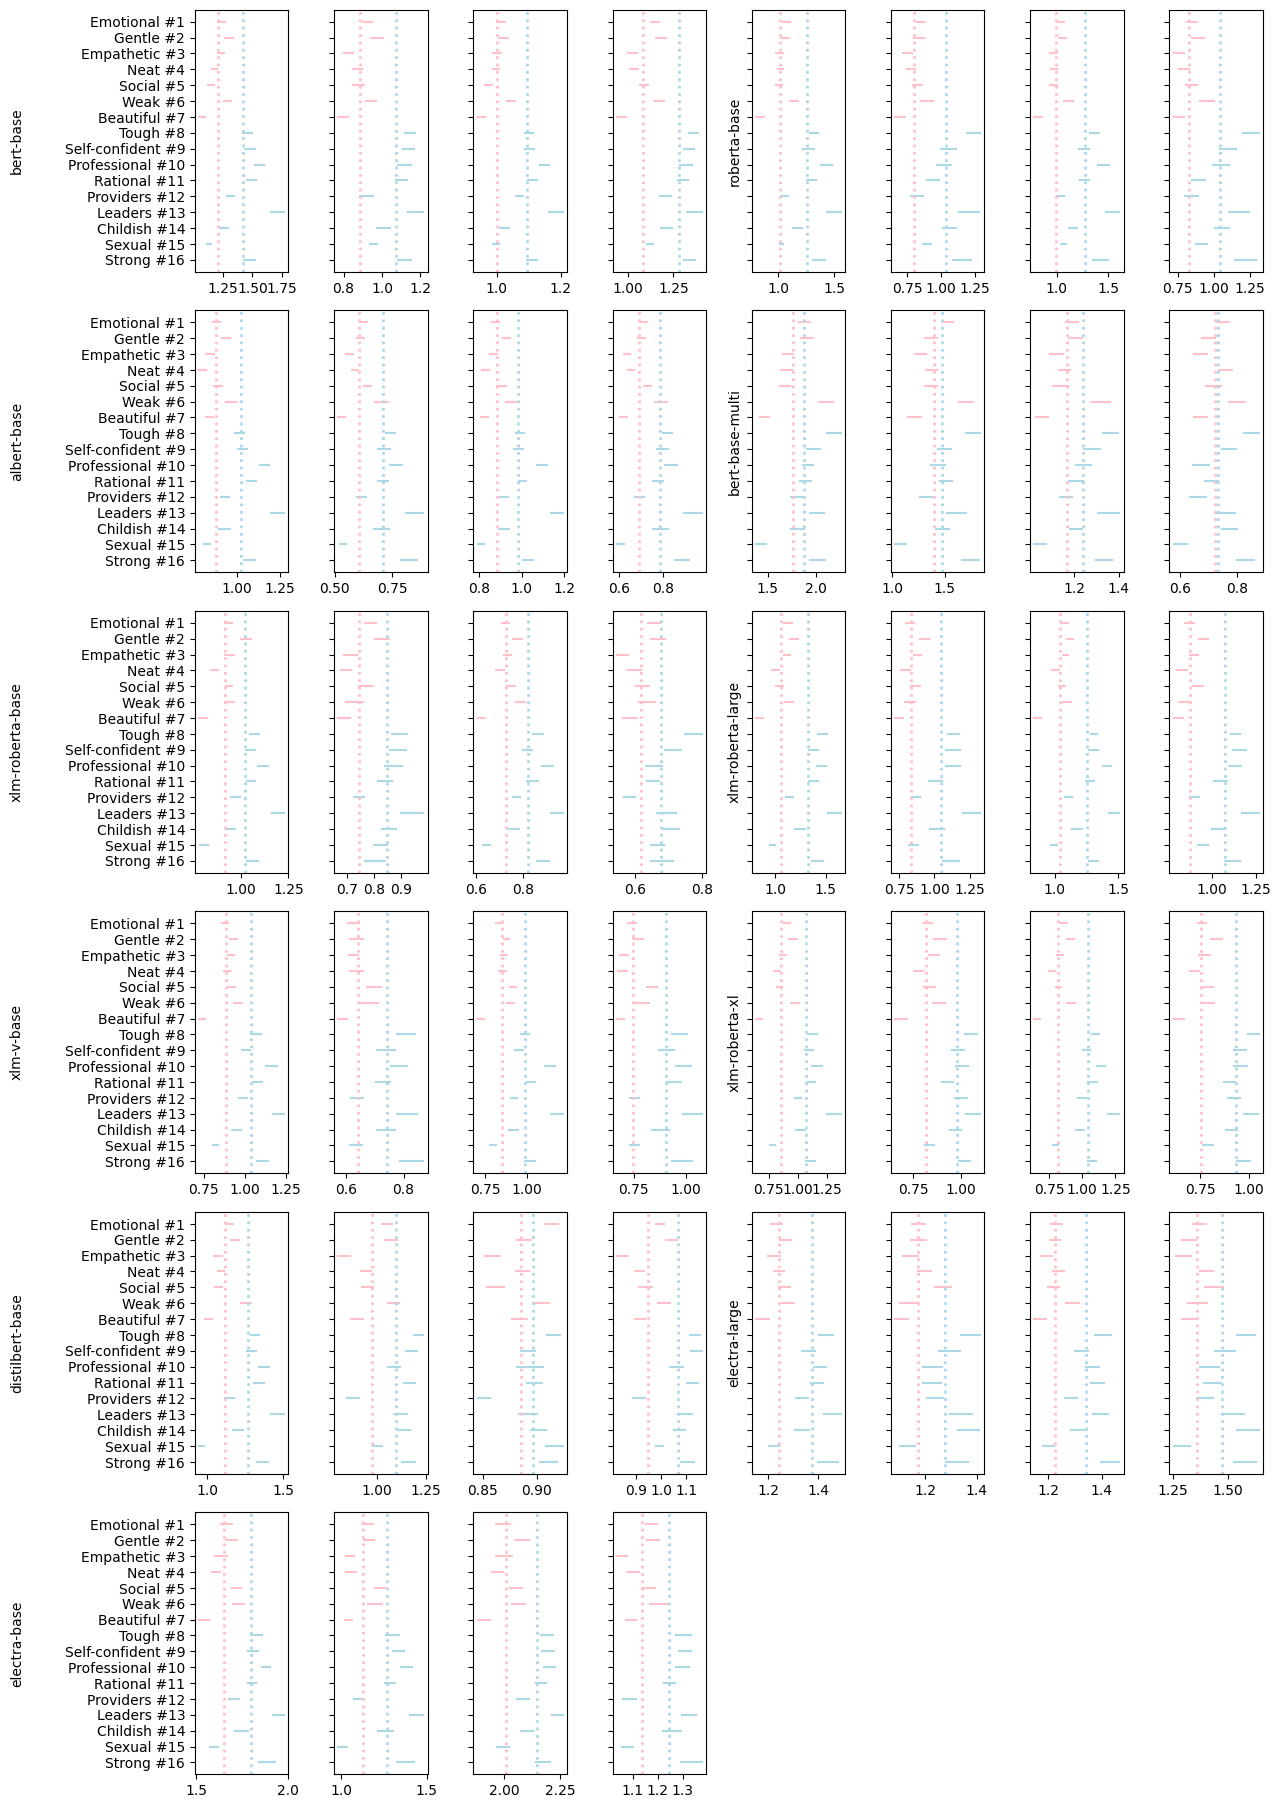

In [7]:
fig, axes = plt.subplots(6, 8, sharey=True)
axes = axes.reshape(-1)
axes[0].invert_yaxis()

for ax in axes[-4:]:
    ax.remove()

for ax, (model, template_id) in zip(axes, product(models, range(4))):
    filename = model_template_file(model, template_id)
    for stereotype_id in range(1, 17):
        _, lower, upper = r_i(filename, stereotype_id)
        ax.plot([lower, upper], [stereotype_id, stereotype_id], c=('pink' if stereotype_id < 8 else 'lightblue'))
    ax.set_yticks(range(1, 17), stereotype_names)
    ax.axvline(r_m(filename), linestyle=':', linewidth=2, color='lightblue')
    ax.axvline(r_f(filename), linestyle=':', linewidth=2, color='pink')
        
    if template_id == 0:
        ax.set_ylabel(short_model_name(model))

set_size(10, 14)
plt.tight_layout()
plt.savefig('./figures/en_all.pdf')

In [8]:
def format_ci(mean, lower, upper):
    return f'{lower:.2f} {mean:.2f} {upper:.2f}'

for model in models:
    print('\\midrule')
    print("& \multicolumn{16}{l}{\\texttt{", end='')
    print(short_model_name(model), end='')
    print("}} \\\\")
    for template_id in range(4):
        print(template_id+1, *[
            format_ci(*r_i(model_template_file(model, template_id), stereotype_id))
            for stereotype_id in range(1, 17)
        ], sep=' & ', end=' \\\\\n')

\midrule
& \multicolumn{16}{l}{\texttt{bert-base}} \\
1 & 1.21 1.24 1.27 & 1.27 1.31 1.34 & 1.21 1.24 1.26 & 1.16 1.18 1.20 & 1.13 1.15 1.17 & 1.26 1.29 1.32 & 1.05 1.08 1.10 & 1.43 1.46 1.49 & 1.44 1.48 1.52 & 1.52 1.56 1.60 & 1.45 1.49 1.54 & 1.28 1.31 1.34 & 1.65 1.71 1.76 & 1.23 1.26 1.30 & 1.12 1.13 1.15 & 1.43 1.48 1.52 \\
2 & 0.90 0.92 0.95 & 0.94 0.97 1.00 & 0.80 0.83 0.85 & 0.85 0.87 0.89 & 0.85 0.88 0.90 & 0.92 0.94 0.97 & 0.77 0.80 0.82 & 1.12 1.15 1.17 & 1.11 1.14 1.17 & 1.08 1.12 1.15 & 1.07 1.10 1.13 & 0.89 0.92 0.95 & 1.13 1.17 1.22 & 0.98 1.01 1.04 & 0.94 0.96 0.97 & 1.09 1.12 1.15 \\
3 & 1.00 1.01 1.03 & 1.01 1.02 1.04 & 0.99 1.00 1.01 & 0.99 1.00 1.01 & 0.96 0.97 0.98 & 1.03 1.04 1.06 & 0.94 0.95 0.96 & 1.09 1.10 1.11 & 1.09 1.10 1.12 & 1.13 1.15 1.16 & 1.10 1.11 1.13 & 1.06 1.07 1.08 & 1.16 1.18 1.21 & 1.01 1.03 1.04 & 0.99 1.00 1.01 & 1.10 1.11 1.13 \\
4 & 1.12 1.15 1.17 & 1.16 1.18 1.21 & 1.00 1.02 1.05 & 1.01 1.03 1.05 & 1.06 1.09 1.11 & 1.15 1.17 1.20 & 0.94 0.96

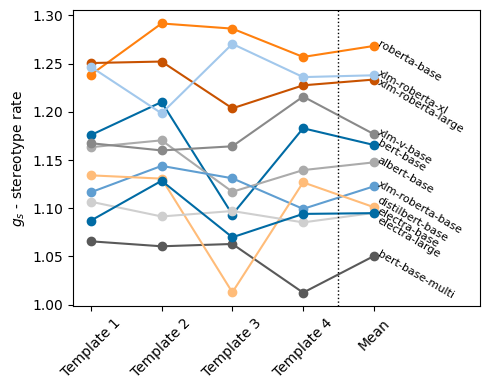

In [15]:
"""
The results are pretty consistent across different templates - This is often not the case with other measures.

The only exception is template #3 with BERT and DistilBERT (note that DistilBERT is directly distilled from the original BERT).
Not sure why that is the case, but it might simply expect different pronouns there.
"""

plt.rcParams["figure.figsize"] = (5,4)

for model in models:
    rates = [
        g_s(model_template_file(model, template_id))
        for template_id in range(4)
    ]
    plt.plot(range(1,6), rates + [np.mean(rates)], marker='o')
    model = short_model_name(model)
    ver_offset = {'distilbert-base': 0.005, 'xlm-roberta-large': -0.005, 'electra-large': -0.010}.get(model, 0)
    plt.text(5 + 0.04, np.mean(rates) + ver_offset, model, fontsize=8, rotation=-30, rotation_mode='anchor')

plt.axvline(4.5, linestyle=':', linewidth=1, color='black')
plt.xticks(range(1, 6), [f'Template {i}' for i in range(1, 5)] + ['Mean'], rotation=45)
plt.xlim(0.75, 6.5)
plt.ylabel('$g_s$ - stereotype rate')
plt.tight_layout()
plt.savefig('./figures/en_templates.pdf')

/tmp/ipykernel_1217/273757315.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


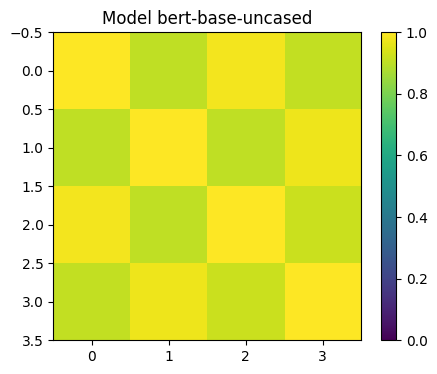

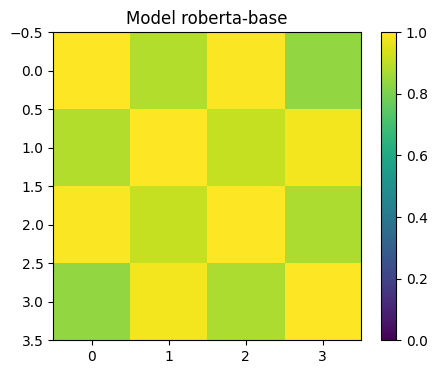

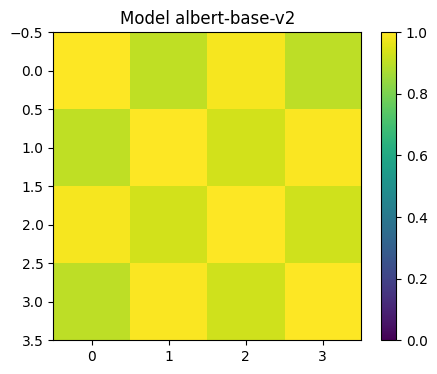

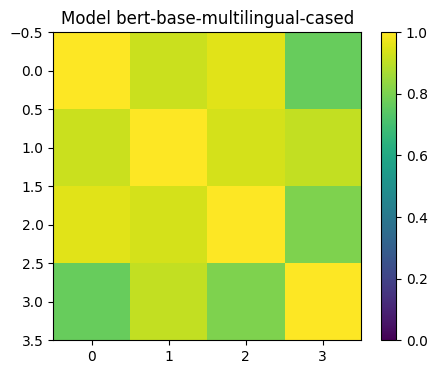

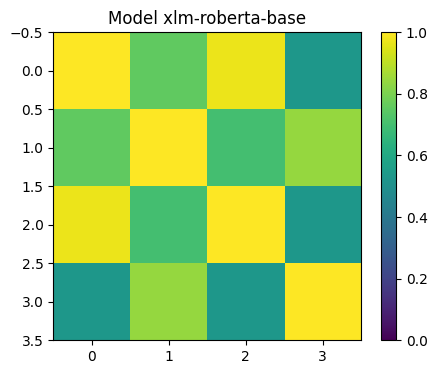

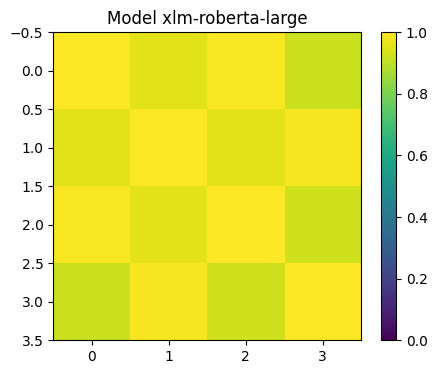

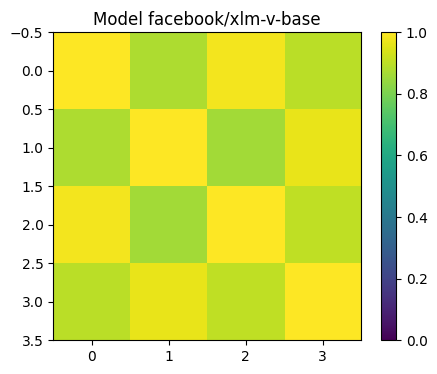

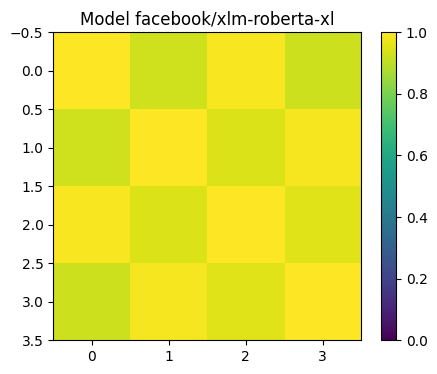

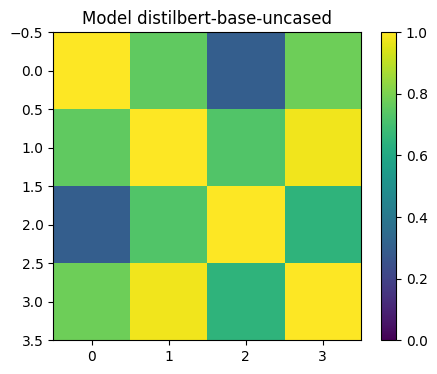

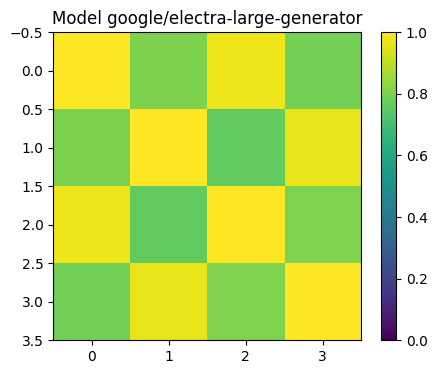

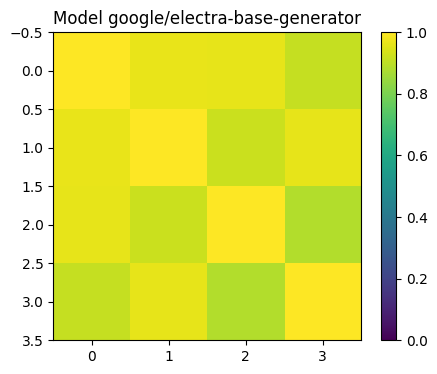

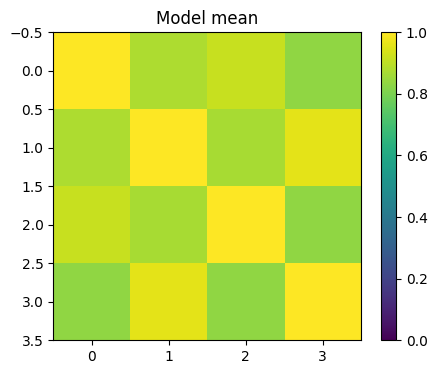

In [10]:
"""
Template correlations.

The correlations are quite strong (0.6+). Correlations between templates that use the same words (X he said, He said X) are much stronger.
This shows certain lexical consistency, that is not the same when we change the gender identifier (he > the man).
"""
corrs = []
for model in models:
    results = np.vstack(
        r_is(model_template_file(model, template_id), bootstrap=False)
        for template_id in range(4)
    )
    corr = np.corrcoef(results)
    corrs.append(corr)
    plt.title(f'Model {model}')
    visualize_corr(corr)
    plt.show()

mean_corrs = np.mean(np.array(corrs), axis=0)
plt.title(f'Model mean')
visualize_corr(mean_corrs)

/tmp/ipykernel_44/3267931227.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


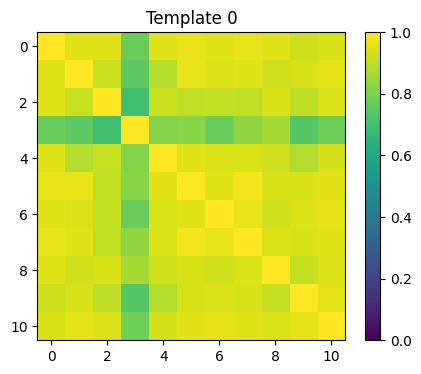

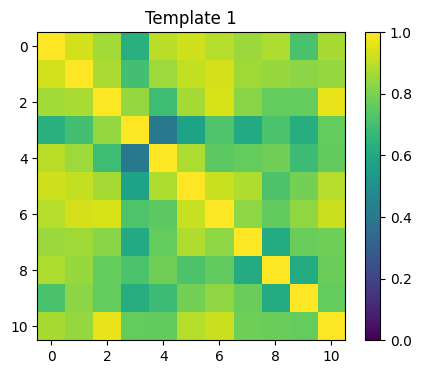

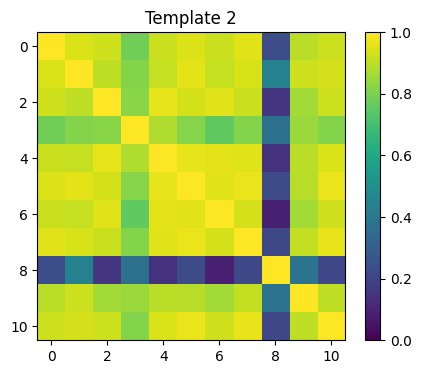

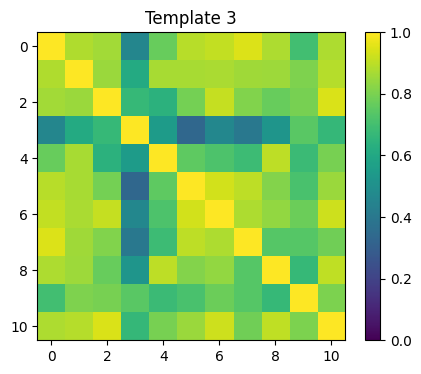

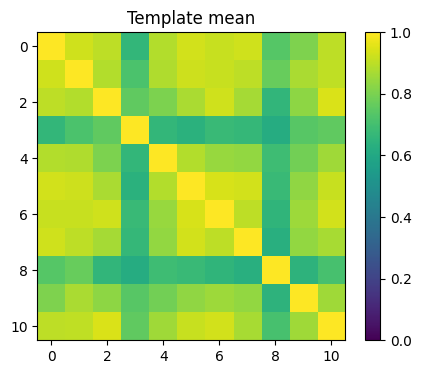

In [44]:
"""
Model correlations.

How the results correlate between models. The correlations are weaker overall (0.5), and they do not say that much.
Only visible pattern is that MBERT is less correlated to the other models.
"""

corrs = []
for template_id in range(4):
    results = np.vstack(
        r_is(model_template_file(model, template_id), bootstrap=False)
        for model in models
    )
    corr = np.corrcoef(results)
    plt.title(f'Template {template_id}')
    visualize_corr(corr)
    plt.show()
    corrs.append(corr)

mean_corr = np.mean(np.array(corrs), axis=0)
plt.title(f'Template mean')
visualize_corr(mean_corr)

Text(0.5, 1.0, 'Normalized')

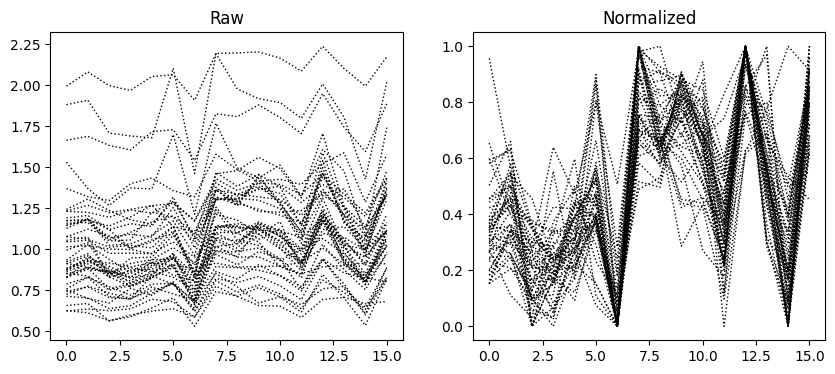

In [11]:
"""
Some (model, template) combinations show either masculine or feminine preference. The stereotypical reasoning is similar in
all of them (the lines are similar), but the base rate (masculine/feminine preference) is different.
"""
plt.rcParams["figure.figsize"] = (10,4)

_, axes = plt.subplots(1, 2)

for model, template_id in product(models, range(4)):
    arr = r_is(model_template_file(model, template_id), bootstrap=False)
    arr = np.array(arr)
    axes[0].plot(arr, c='black', linestyle=':', linewidth=1)
    arr -= min(arr)
    arr /= max(arr)
    axes[1].plot(arr, c='black', linestyle=':', linewidth=1)
axes[0].set_title('Raw')
axes[1].set_title('Normalized')



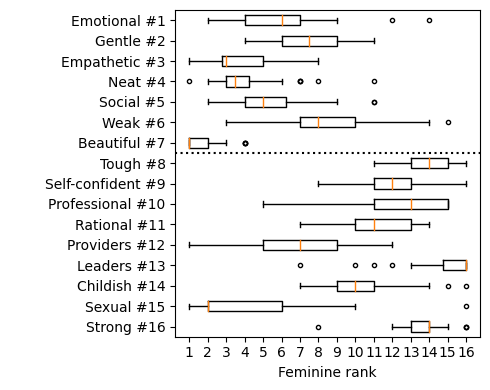

In [12]:
"""
Boxplot of positions (the rank in the list of 16 stereotypes) for all stereotypes.
"""
plt.rcParams["figure.figsize"] = (5,4)

ranks = np.vstack([
    r_i_ranks(model_template_file(model, template_id))
    for model in models
    for template_id in range(4)
])
plt.boxplot([ranks[:,i] for i in range(16)], vert=False, sym='.')
plt.axhline(7.5, c='black', linestyle=':')
plt.gca().invert_yaxis()
plt.xticks(range(1,17))
plt.yticks(range(1,17), stereotype_names)
plt.xlabel('Feminine rank')
plt.tight_layout()

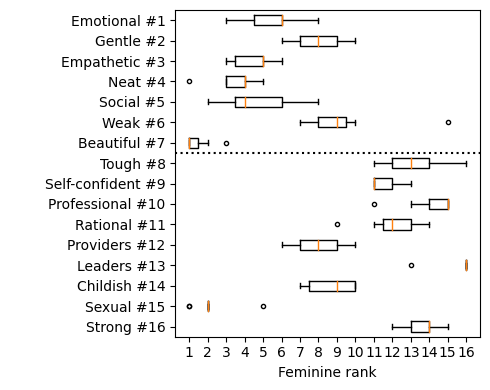

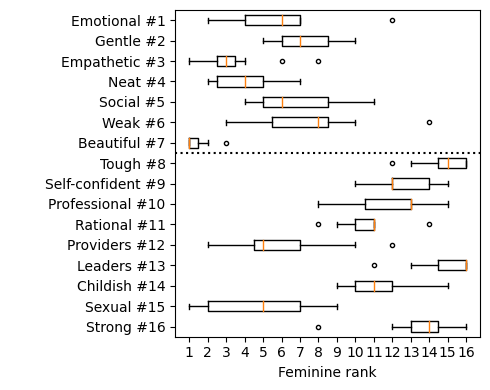

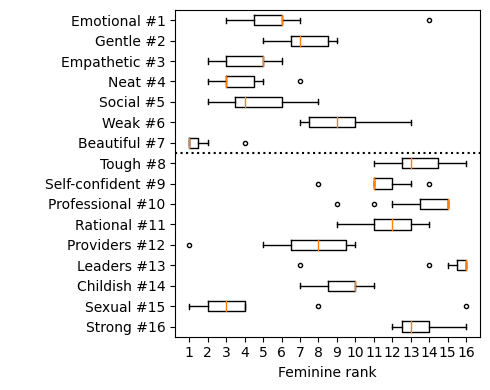

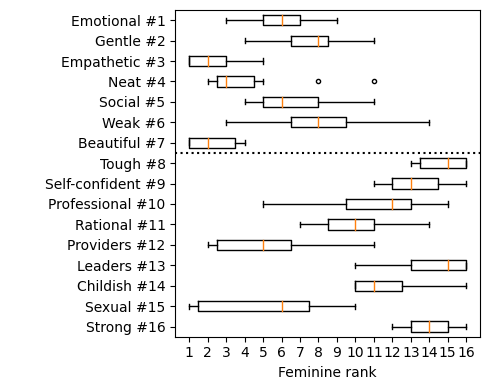

In [13]:
"""
Boxplots for templates. They look pretty similar to each other. "he/she" templates are more consistent than "man/woman".
"""
plt.rcParams["figure.figsize"] = (5,4)

for template_id in range(4):
    ranks = np.vstack([
        r_i_ranks(model_template_file(model, template_id))
        for model in models
    ])
    plt.boxplot([ranks[:,i] for i in range(16)], vert=False, sym='.')
    plt.axhline(7.5, c='black', linestyle=':')
    plt.gca().invert_yaxis()
    plt.xticks(range(1,17))
    plt.yticks(range(1,17), stereotype_names)
    plt.xlabel('Feminine rank')
    plt.tight_layout()
    plt.show()


### MultiBERT

We do not include the predictions calculated for MultiBERT within the repository due to its size (50MB), but the inference code is available. The predictions are also available upon request.

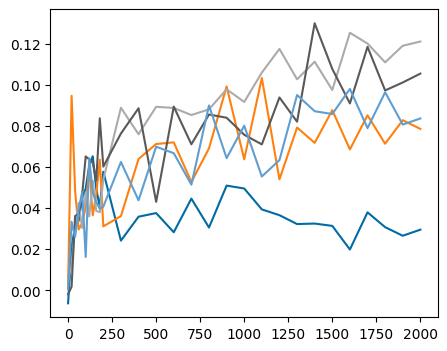

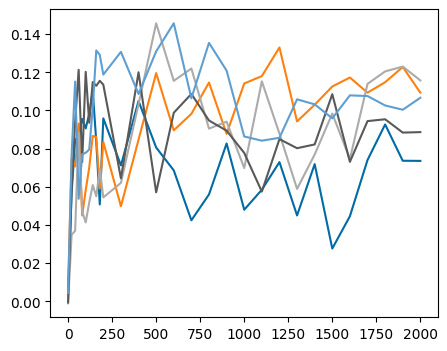

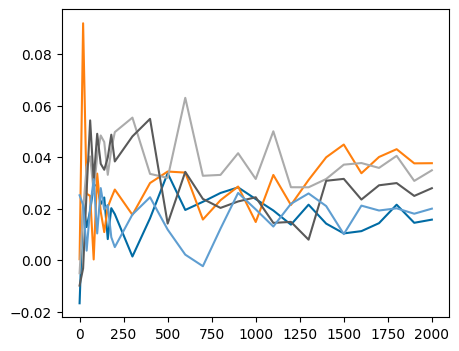

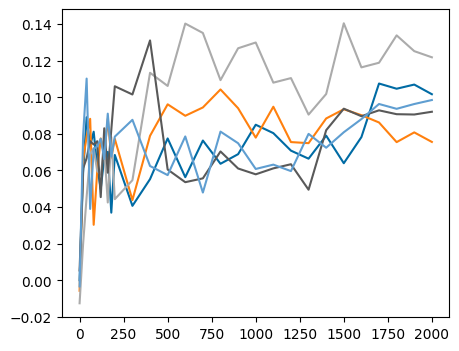

In [18]:
"""
Evolution during a BERT training run. Seems pretty consistent after the initial spike.

Template #3 is a bit lower, similar to how it behaves for regular BERT in Figure 4. This suggest that the drop there
is somehow connected to the data.
"""

import glob
import re

pred_files = glob.glob('./cache/predictions/multibert/*seed_0*')
steps = sorted(set(
    int(re.findall(r'([0-9]+)k', filename)[0])
    for filename in pred_files
    if 'k' in filename
))

def multibert_filename(seed_id, step_count, template_id):
    return f'./cache/predictions/multibert/multiberts-seed_{seed_id}-step_{step_count}k_template-{template_id}.txt'


for template_id in range(4):
    for seed_id in range(5):
        plt.plot(
            steps,
            [
                g_s(multibert_filename(seed_id, step, template_id))
                for step in steps
            ]
        )
    plt.show()

/tmp/ipykernel_1431/2943152320.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  results = np.vstack(


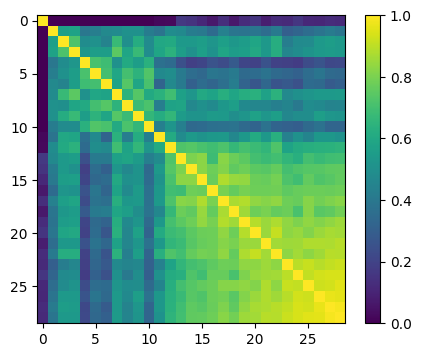

In [19]:
"""
Correlation of the scores for individual checkpoints.
"""
results = np.vstack(
    file_results(multibert_filename(0, step, 0))
    for step in steps
)
corr = np.corrcoef(results)
visualize_corr(corr)

### Family-related terms

1.1444152738045035 0.9990921656179033 0.9758599612953085


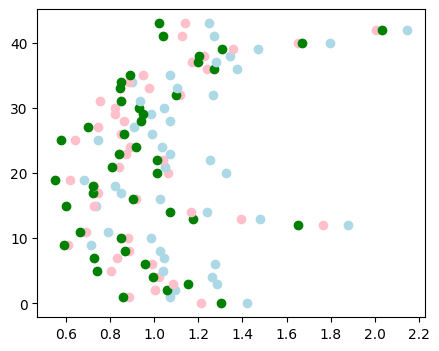

In [17]:
family_words = 'family child children partner kids kid family\'s'.split()

def family_rate(filename):
    return np.exp(np.mean([
        val
        for val, sentence, stereotype_id in zip(file_results(filename), gest.sentence, gest.stereotype)
        if any(word in sentence for word in family_words) and stereotype_id > 7
    ]))

al, bl, cl = [], [], []
for i, (model, template_id) in enumerate(product(models, range(4))):
    filename = model_template_file(model, template_id)
    a, b, c = r_m(filename), r_f(filename), family_rate(filename)
    plt.scatter([a], [i], c='lightblue')
    plt.scatter([b], [i], c='pink')
    plt.scatter([c], [i], c='green')
    al.append(a); bl.append(b); cl.append(c)
print(np.mean(al), np.mean(bl), np.mean(cl))


## GLM visualizations

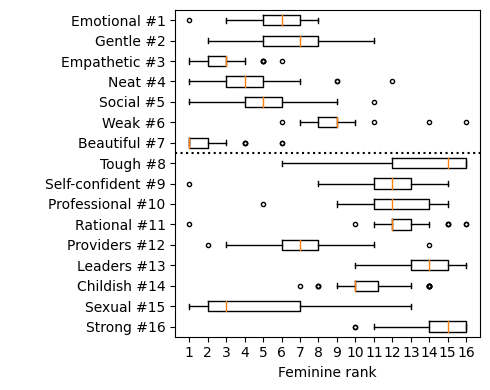

In [52]:
"""
Boxplot of positions (the rank in the list of 16 stereotypes) for all stereotypes.
"""
import glob
plt.rcParams["figure.figsize"] = (5,4)

ranks = np.vstack([
    r_i_ranks(model_template_file(model, template_id, True))
    for model in gmodels
    for template_id in range(2)
])

plt.boxplot([ranks[:,i] for i in range(16)], vert=False, sym='.')
plt.axhline(7.5, c='black', linestyle=':')
plt.gca().invert_yaxis()
plt.xticks(range(1,17))
plt.yticks(range(1,17), stereotype_names)
plt.xlabel('Feminine rank')
plt.tight_layout()
# plt.savefig('./figures/en_g_ranks.pdf')

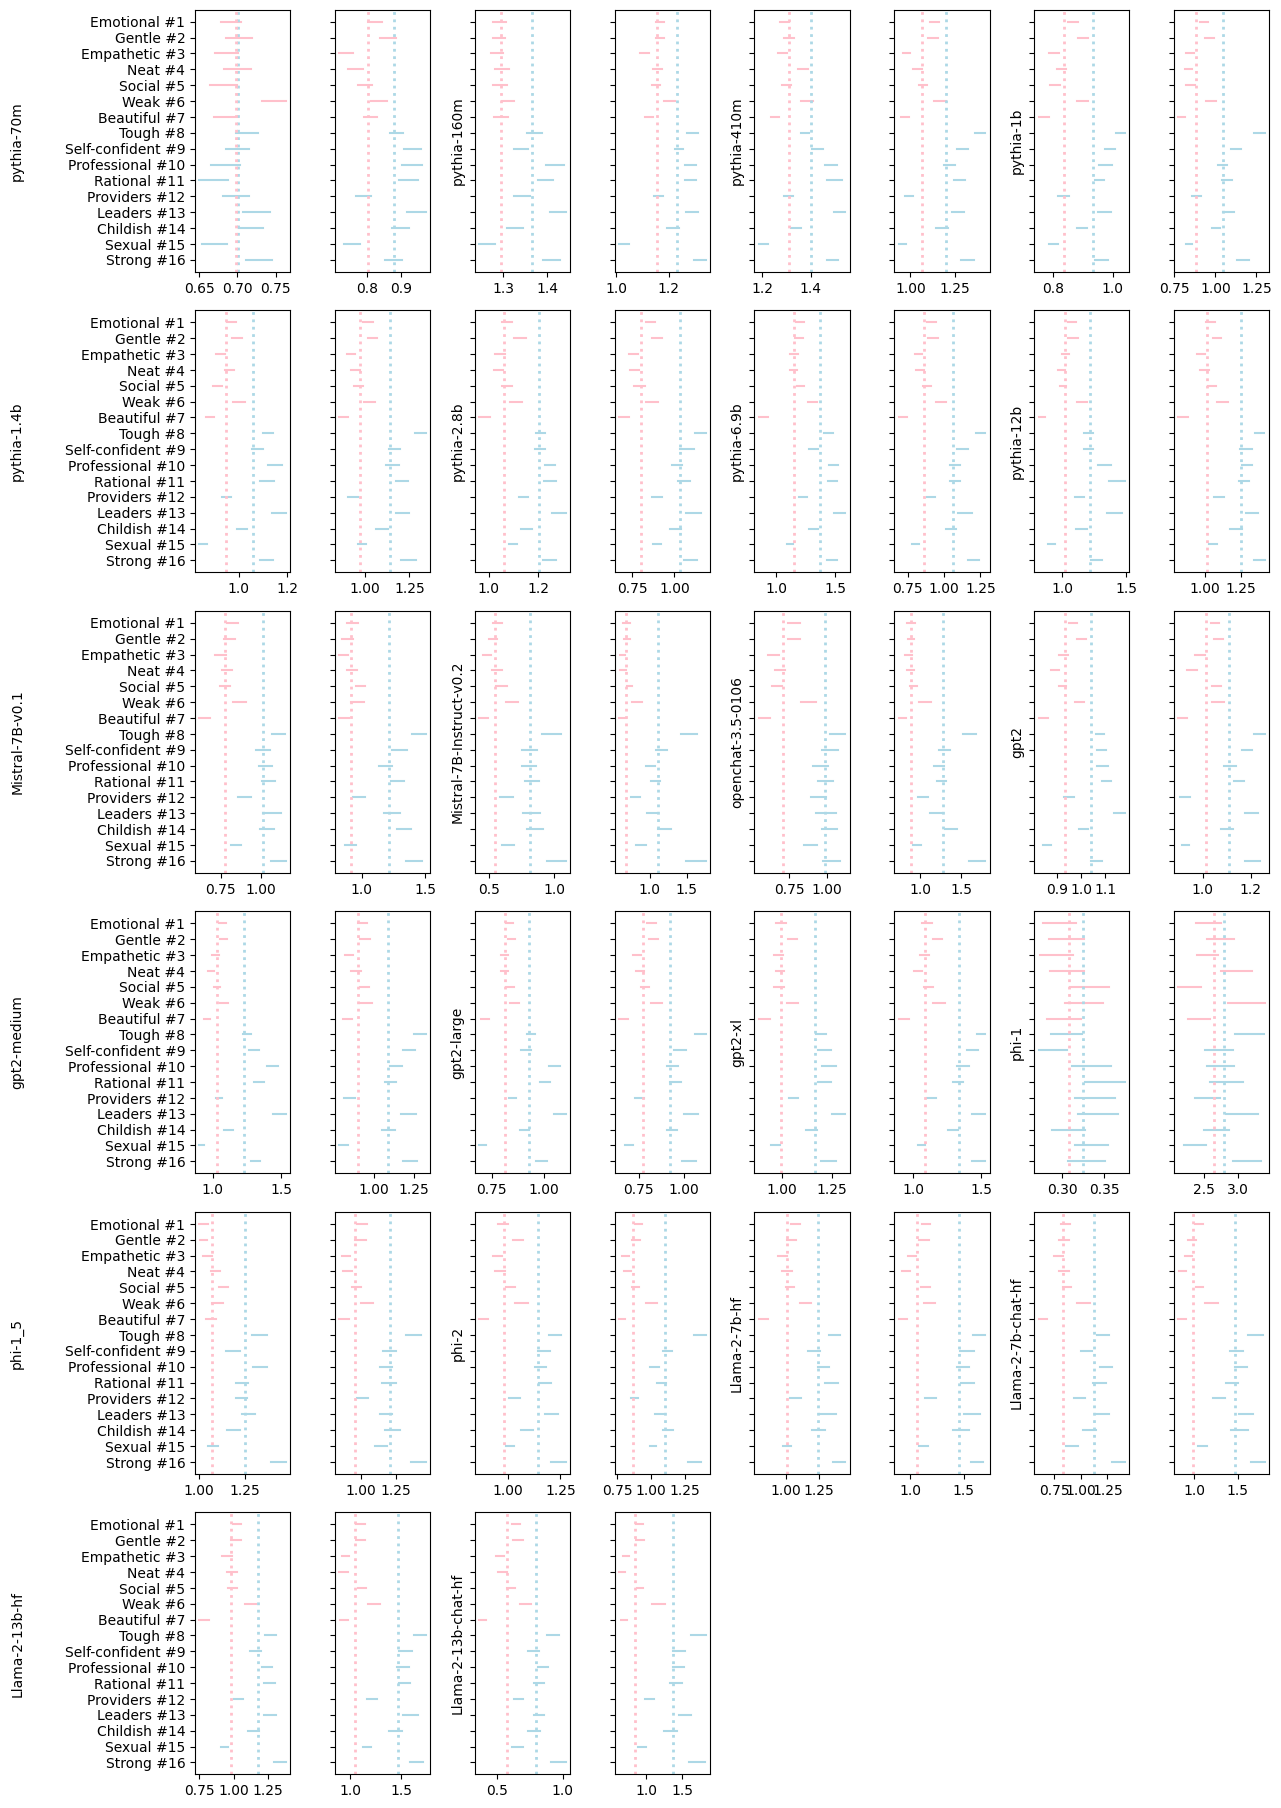

In [18]:
fig, axes = plt.subplots(6, 8, sharey=True)
axes = axes.reshape(-1)
axes[0].invert_yaxis()

for ax in axes[-4:]:
    ax.remove()

for ax, (model, template_id) in zip(axes, product(gmodels, range(2))):
    filename = model_template_file(model, template_id, True)
    for stereotype_id in range(1, 17):
        _, lower, upper = r_i(filename, stereotype_id)
        ax.plot([lower, upper], [stereotype_id, stereotype_id], c=('pink' if stereotype_id < 8 else 'lightblue'))
    ax.set_yticks(range(1, 17), stereotype_names)
    ax.axvline(r_m(filename), linestyle=':', linewidth=2, color='lightblue')
    ax.axvline(r_f(filename), linestyle=':', linewidth=2, color='pink')
        
    if template_id == 0:
        ax.set_ylabel(short_model_name(model))

set_size(10, 14)
plt.tight_layout()
plt.savefig('./figures/en_g_all.pdf')

In [19]:
def format_ci(mean, lower, upper):
    return f'{lower:.2f} {mean:.2f} {upper:.2f}'

for model in gmodels:
    print('\\midrule')
    print("& \multicolumn{16}{l}{\\texttt{", end='')
    print(short_model_name(model), end='')
    print("}} \\\\")
    for template_id in range(2):
        print(template_id+1, *[
            format_ci(*r_i(model_template_file(model, template_id, True), stereotype_id))
            for stereotype_id in range(1, 17)
        ], sep=' & ', end=' \\\\\n')

\midrule
& \multicolumn{16}{l}{\texttt{pythia-70m}} \\
1 & 0.68 0.69 0.71 & 0.69 0.70 0.72 & 0.67 0.69 0.70 & 0.68 0.70 0.72 & 0.66 0.68 0.70 & 0.73 0.75 0.76 & 0.67 0.68 0.70 & 0.70 0.71 0.73 & 0.69 0.70 0.71 & 0.67 0.69 0.71 & 0.65 0.67 0.69 & 0.68 0.70 0.71 & 0.71 0.72 0.74 & 0.70 0.72 0.73 & 0.65 0.67 0.69 & 0.71 0.73 0.74 \\
2 & 0.80 0.82 0.84 & 0.84 0.86 0.88 & 0.72 0.74 0.76 & 0.74 0.77 0.79 & 0.78 0.80 0.82 & 0.81 0.83 0.86 & 0.79 0.81 0.83 & 0.87 0.89 0.91 & 0.91 0.93 0.96 & 0.90 0.93 0.96 & 0.90 0.92 0.95 & 0.77 0.79 0.81 & 0.92 0.95 0.97 & 0.87 0.90 0.92 & 0.73 0.76 0.78 & 0.85 0.88 0.90 \\
\midrule
& \multicolumn{16}{l}{\texttt{pythia-160m}} \\
1 & 1.28 1.29 1.31 & 1.28 1.29 1.30 & 1.27 1.29 1.30 & 1.28 1.30 1.31 & 1.28 1.29 1.31 & 1.30 1.31 1.33 & 1.28 1.29 1.31 & 1.36 1.37 1.39 & 1.32 1.34 1.36 & 1.40 1.42 1.44 & 1.38 1.40 1.41 & 1.32 1.34 1.36 & 1.41 1.42 1.44 & 1.31 1.33 1.34 & 1.25 1.26 1.28 & 1.39 1.41 1.43 \\
2 & 1.15 1.17 1.18 & 1.15 1.17 1.18 & 1.09 1.11 1.12 & 1.1

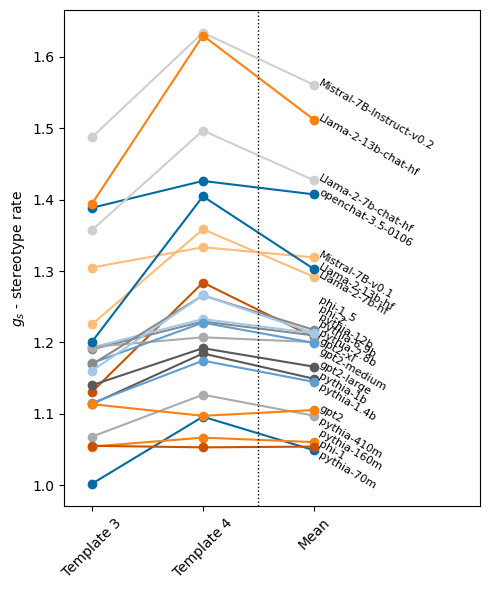

In [43]:
"""
The results are pretty consistent across different templates - This is often not the case with other measures.

The only exception is template #3 with BERT and DistilBERT (note that DistilBERT is directly distilled from the original BERT).
Not sure why that is the case, but it might simply expect different pronouns there.
"""

plt.rcParams["figure.figsize"] = (5,6)

for model in gmodels:
    rates = [
        g_s(model_template_file(model, template_id, True))
        for template_id in range(2)
    ]
    plt.plot(range(1,4), rates + [np.mean(rates)], marker='o')
    model = short_model_name(model)
    ver_offset = {'pythia-70m': -0.01, 'pythia-160m': 0.01, 'pythia-410m': -0.01, 'pythia-1.4b': -0.01,
                 'gpt2-medium': -0.015, 'phi-1_5': 0.04, 'phi-2': 0.03, 'pythia-12b': 0.02, 'pythia-6.9b': 0.013, 'pythia-2.8b': 0.003}.get(model, 0)
    plt.text(3 + 0.04, np.mean(rates) + ver_offset, model, fontsize=8, rotation=-30, rotation_mode='anchor')

plt.axvline(2.5, linestyle=':', linewidth=1, color='black')
plt.xticks(range(1, 4), [f'Template {i}' for i in range(3, 5)] + ['Mean'], rotation=45)
plt.xlim(0.75, 4.5)
plt.ylabel('$g_s$ - stereotype rate')
plt.tight_layout()
plt.savefig('./figures/en_g_templates.pdf')

### Family-related terms

1.1649416497181024 0.9573645067270935 0.9553596709034395


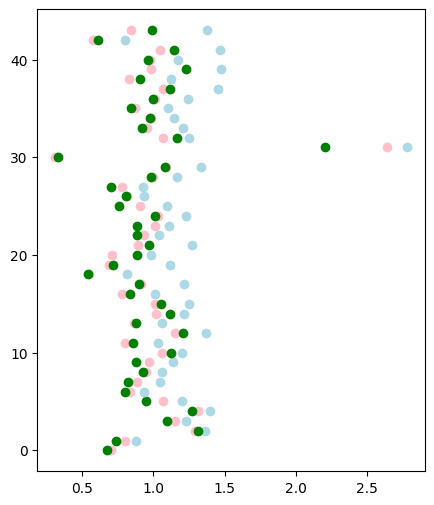

In [21]:
family_words = 'family child children partner kids kid family\'s'.split()

def family_rate(filename):
    return np.exp(np.mean([
        val
        for val, sentence, stereotype_id in zip(file_results(filename), gest.sentence, gest.stereotype)
        if any(word in sentence for word in family_words) and stereotype_id > 7
    ]))

al, bl, cl = [], [], []
for i, (model, template_id) in enumerate(product(gmodels, range(2))):
    filename = model_template_file(model, template_id, True)
    a, b, c = r_m(filename), r_f(filename), family_rate(filename)
    plt.scatter([a], [i], c='lightblue')
    plt.scatter([b], [i], c='pink')
    plt.scatter([c], [i], c='green')
    al.append(a); bl.append(b); cl.append(c)
print(np.mean(al), np.mean(bl), np.mean(cl))


## MLM + GLM visualizations

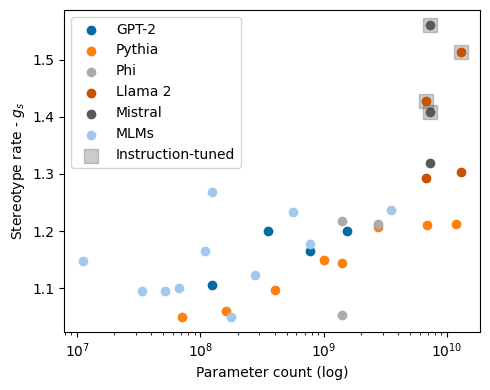

In [22]:
plt.rcParams["figure.figsize"] = (5,4)

for model, param_count in gmodels.items():
    score = np.mean([g_s(model_template_file(model, template_id, True)) for template_id in range(2)])
    if 'chat' in model or 'Instruct' in model:
        plt.scatter([param_count], [score], c='black', marker='s', alpha=0.2, s=90)
        
    if 'gpt2' in model:
        c = 'C0'
    elif 'pythia' in model:
        c = 'C1'
    elif 'phi-' in model:
        c = 'C2'
    elif 'Llama-' in model:
        c = 'C5'
    else:
        c = 'C3'
    plt.scatter([param_count], [score], c=c)

for model, param_count in models.items():
    gs = np.mean([g_s(model_template_file(model, template_id)) for template_id in range(4)])
    plt.scatter([param_count], [gs], c='C7')
    
plt.scatter([], [], c='C0', label='GPT-2')
plt.scatter([], [], c='C1', label='Pythia')
plt.scatter([], [], c='C2', label='Phi')
plt.scatter([], [], c='C5', label='Llama 2')
plt.scatter([], [], c='C3', label='Mistral')
plt.scatter([], [], c='C7', label='MLMs')
plt.scatter([], [], c='black', marker='s', alpha=0.2, s=90, label='Instruction-tuned')
plt.legend()

plt.xscale('log')
plt.xlabel('Parameter count (log)')
plt.ylabel('Stereotype rate - $g_s$')
plt.tight_layout()
plt.savefig('./figures/en_perf.pdf')

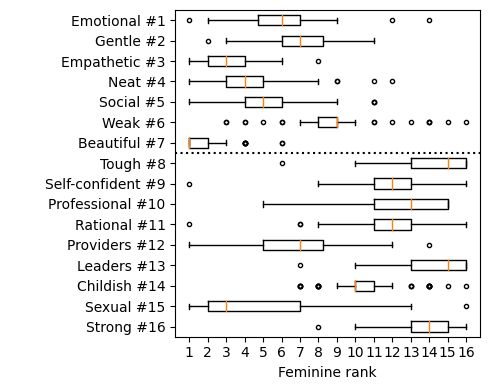

In [23]:
"""
Boxplot of positions (the rank in the list of 16 stereotypes) for all stereotypes.
"""
import glob

plt.rcParams["figure.figsize"] = (5,4)

ranks_m = np.vstack([
    r_i_ranks(model_template_file(model, template_id))
    for model in models
    for template_id in range(4)
])

ranks_g = np.vstack([
    r_i_ranks(model_template_file(model, template_id, True))
    for model in gmodels
    for template_id in range(2)
])

ranks = np.vstack([ranks_m, ranks_g])
plt.boxplot([ranks[:,i] for i in range(16)], vert=False, sym='.')
plt.axhline(7.5, c='black', linestyle=':')
plt.gca().invert_yaxis()
plt.xticks(range(1,17))
plt.yticks(range(1,17), stereotype_names)
plt.xlabel('Feminine rank')
plt.tight_layout()
plt.savefig('./figures/en_ranks.pdf')


### Correlations

Correlations calculated across scores for individual instances `instance_results` and score for stereotypes `r_i_results`.

In [44]:
instance_results = {
    (model, template_id): file_results(model_template_file(model, template_id))
    for model, template_id in product(models, range(4))
}
r_i_results = {
    (model, template_id): r_is(model_template_file(model, template_id), bootstrap=False)
    for model, template_id in product(models, range(4))
}

In [45]:
"""
Mean correlation between models
"""
from itertools import chain

def correlation(model_file_1, model_file_2, template_1, template_2, use_r_is=True, generative=False):
    local_r_is = lambda x: r_is(x, bootstrap=False)
    func = local_r_is if use_r_is else file_results
    field_1 = func(model_template_file(model_file_1, template_1, generative))
    field_2 = func(model_template_file(model_file_2, template_2, generative))
    return pearsonr(field_1, field_2)[0]

In [46]:
"""
Average r_i correlation between different models using the same template
"""

vals = [
    correlation(m1, m2, t, t)
    for m1, m2 in combinations(models, 2)
    for t in range(4)
] + [
    correlation(m1, m2, t, t, generative=True)
    for m1, m2 in combinations(gmodels, 2)
    for t in range(2)
]
np.mean(vals)

0.829579264238822

In [47]:
"""
Average r_i correlation between the same models using different templates
"""

vals = [
    correlation(m, m, t1, t2)
    for m in models
    for t1, t2 in combinations(range(4), 2)
] + [
    correlation(m, m, t1, t2, generative=True)
    for m in gmodels
    for t1, t2 in combinations(range(2), 2)
]
np.mean(vals)

0.8720227956334885

In [48]:
"""
Average instance-level correlation between different models using the same template
"""

vals = [
    correlation(m1, m2, t, t, use_r_is=False)
    for m1, m2 in combinations(models, 2)
    for t in range(4)
] + [
    correlation(m1, m2, t, t, use_r_is=False, generative=True)
    for m1, m2 in combinations(gmodels, 2)
    for t in range(2)
]
np.mean(vals)

0.5022795179070525

In [49]:
"""
Average instance-level correlation between the same models using different templates
"""

vals = [
    correlation(m, m, t1, t2, use_r_is=False)
    for m in models
    for t1, t2 in combinations(range(4), 2)
] + [
    correlation(m, m, t1, t2, use_r_is=False, generative=True)
    for m in gmodels
    for t1, t2 in combinations(range(2), 2)
]
np.mean(vals)

0.7031258788572078

## WinoBias comparison

In [5]:
import pandas as pd

def winobias_score(model_name, dataset_type, dataset_split):
    df = pd.read_csv('./data/predictions/winobias/winobias.csv')
    row = df.query(f'model_name == "{model_name}" & dataset_type == {dataset_type} & dataset_split == "{dataset_split}"')
    row = row.iloc[0]
    return float(np.exp(row.logprob_male_professions - row.logprob_female_professions))


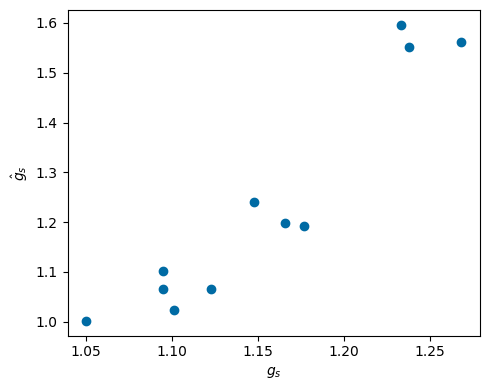

In [17]:
winobias_scores = [winobias_score(model, '1', 'test') for model in models]
gest_scores = [
    np.mean([
        g_s(model_template_file(model, template_id))
        for template_id in range(4)
    ])
    for model in models
]

plt.rcParams["figure.figsize"] = (5,4)
plt.scatter(gest_scores, winobias_scores)
plt.xlabel('$g_s$')
plt.ylabel('$\hat{g}_s$')
pearsonr(winobias_scores, gest_scores)
plt.tight_layout()
plt.savefig('./figures/winobias.pdf')

In [7]:
winobias_scores = [winobias_score(model, '1', 'test') for model in models]

for stereotype_id in range(1, 17):
    gest_scores = [
        np.mean([
            r_i(model_template_file(model, template_id), stereotype_id)
            for template_id in range(4)
        ])
        for model in models
    ]
    print(stereotype_id, pearsonr(winobias_scores, gest_scores))
    

1 PearsonRResult(statistic=-0.41536117091257535, pvalue=0.20393809094314436)
2 PearsonRResult(statistic=-0.3743503131276613, pvalue=0.25669269126803596)
3 PearsonRResult(statistic=-0.32922190370963234, pvalue=0.32284997647951047)
4 PearsonRResult(statistic=-0.43438402655218955, pvalue=0.18187360766292393)
5 PearsonRResult(statistic=-0.4080611557107874, pvalue=0.21281013268767326)
6 PearsonRResult(statistic=-0.42155018010144296, pvalue=0.19659229931075714)
7 PearsonRResult(statistic=-0.4977138847305784, pvalue=0.11926180592856646)
8 PearsonRResult(statistic=-0.18584405958645644, pvalue=0.5843047517165295)
9 PearsonRResult(statistic=-0.20024116193470504, pvalue=0.554958806678163)
10 PearsonRResult(statistic=-0.10639215647871729, pvalue=0.7555402465453432)
11 PearsonRResult(statistic=-0.2722474077988928, pvalue=0.41799428218298107)
12 PearsonRResult(statistic=-0.2902816069955757, pvalue=0.38652977042166403)
13 PearsonRResult(statistic=-0.03665129794399202, pvalue=0.9148016994694922)
14 Pe

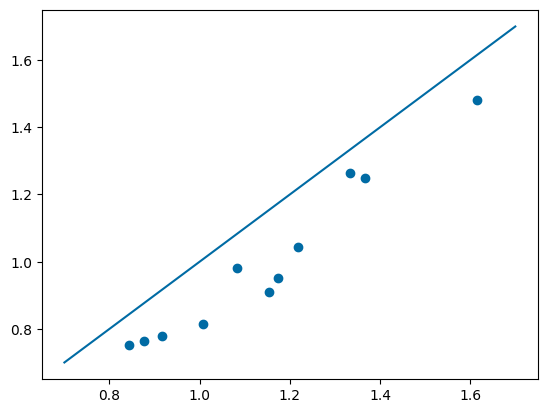

In [49]:
m = [
    np.mean([
        r_m(model_template_file(model, template_id))
        for template_id in range(4)
    ])
    for model in models
]

f = [
    np.mean([
        r_f(model_template_file(model, template_id))
        for template_id in range(4)
    ])
    for model in models
]

plt.scatter(m, f)
plt.plot([0.7, 1.7], [0.7, 1.7])
